**Họ và tên: Nguyễn Quốc An**  
**MSSV: 18020106**  
**Lớp: K63CACLC2**  

**Vấn đề** có thể giúp ích được gì   
**Giải phasp** vẽ biểu đồ để rút ra nhận xét hoặc tạo feature mới hoặc clean data  
**Nhận xest** kết quả ntn, đã ổn chưa, chưa ổn ở chỗ nào =>> Hướng xử lí  
**Hướng xử lí**  

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
from tqdm import tqdm
import scipy.signal as sg
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy.signal import lfilter
from scipy import stats
import os

# **Tổng quan bài toán** 

## Bài toán:

Dự đoán khoảng thời gian còn lại cho đến khi xảy ra động đất tiếp theo dựa vào dữ liệu đia chấn đã ghi nhận được. Đây là động đất được tạo ra trong phòng thí nghiệm, mô tả một trận động đất thông thường  
**Vấn đề cần giải quyết:** https://www.kaggle.com/c/LANL-Earthquake-Prediction  
**Phân loại vấn đề:** Trong học máy, bài toán này thuộc nhóm bài toán hồi quy. 

## Tổng quan về dữ liệu

**Mục đích** của tổng qua dữ liệu là xem các đặc điểm của dữ liệu về độ lớn của tập dữ liệu, số trường dữ liệu, kiểu dữ liệu tại mỗi trường để có các phương pháp triển khai hợp lí.  

### Dữ liệu huấn luyện

**Công việc:** <br>
- Mô tả độ lớn của file chứa dữ liệu
- Mô tả số số hàng: Do không thể tải toàn bộ file nên số liệu được tham khảo trên kaggle
- Mô tả các trường dữ lệu 
- Mô tả kiểu dữ liệu của từng trường 

In [18]:
print("Độ lớn của file train chứa dữ liệu:",Path('data/train.csv').stat().st_size, "bytes", '\n')
train = pd.read_csv('data/train.csv', nrows=6000000)
print("In ra 5 dòng đầu tiên trong dữ liệu:")
print(train[:5], '\n')
print("Số hàng: 629000000 điểm dữ liệu", '\n')
print("In ra ra kiểu dữ liệu của từng trường:")
train.info()

Độ lớn của file train chứa dữ liệu: 9555558244 bytes 

In ra 5 dòng đầu tiên trong dữ liệu:
   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691 

Số hàng: 629000000 điểm dữ liệu 

In ra ra kiểu dữ liệu của từng trường:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acoustic_data    int64  
 1   time_to_failure  float64
dtypes: float64(1), int64(1)
memory usage: 91.6 MB


**Bình luận:** 
- **Độ lớn của tập huấn luyện:** Đối với em, đây là một bộ dữ liệu lớn gây ra rất nhiều khó khăn trong điều kiện thiết bị không thể tải được toàn bộ dữ liệu vào. Em đã tìm hiểu khác nhau để tải và xử dụng dữ liệu:
    - **Cách 1: Dùng google colab để móc dữ liệu về qua Kaggle API:**
            - Ưu điểm: Tốc độ Download nhanh. Xử dụng được colab với sự hỗ trợ của GPU.
            - Nhược điểm: Dữ liệu lưu tạm thời trên máy ảo. Mỗi lần tải lại lại mất.
    - **Cách 2: Dùng jupyter notebook ở local:**
            - Ưu điểm: Có thể train khi không có mạng. Không phải tải lại bộ dữ liệu.
            - Nhược điểm: Không có GPU. Không thể đọc một lúc toàn bộ file train  
- **Các trường dữ liệu:**: Dữ liệu có dạng timeseries nên chỉ gồm 2 cột là acousstic_data là tín hiệu và time_to_failure là thời gian còn lại từ tín hiệu đó cho đến trận động đất tiếp theo. 
- **Kiểu dữ liệu cả các trường:** Dữ liệu **acoustic_data** có trường `int64` lớn có thể hạ xuống `int16` để giảm bộ nhớ. **time_to_failure** cũng có trường `float64`, tuy nhiên thời gian cần được biểu diễn chính xác nên không hạ xuống trường thấp hơn. <br>


**Hướng xử lí**
- **Độ lớn của tập huấn luyện:** Sau quá trình cân nhắc, em đã lựa chọn ***cách 2*** cùng với chiến lược khắc phục nhược điểm bằng cách **khi visualization** chỉ sử dụng một phần tập train. **Khi trích chọn đặc trưng** thì dùng cửa sổ trượt để đọc từng segment một.   
- **Kiểu dữ liệu cả các trường:** Dữ liệu **acoustic_data** hạ xuống `int16` để giảm bộ nhớ. 

### Dữ liệu kiểm tra

Mục đích được trình bày ở phía trên.
Do các dữ liệu kiểm tra được chia ra thành các segment. Mỗi segment chứa trong 1 file nên phần công việc hơi khác một chút gồm có:
- Mô tả số lượng segment trong thư mục test
- Mô tả độ lớn trung bình của file chứa dữ liệu
- Mô tả các trường dữ lệu
- Mô tả kiểu dữ liệu của từng trường

In [107]:
path, dirs, files = next(os.walk("data/test"))
file_count = len(files)
print('Số segment trong thư mục test là', file_count, '\n')

file_size = 0
for file in files:
    file_size += Path("data/test/" + file).stat().st_size
file_size = file_size/file_count 
print("Kích thước trung bình của một segment là", file_size, "bytes",'\n')

test1 = pd.read_csv('data/test/seg_00030f.csv') 
print("In ra 5 dòng đầu tiên trong dữ liệu:")
print(test1[:5], '\n')

print("Số điểm dữ liệu trong 1 segment:", len(test1), '\n')

print('Kiểu dữ liệu của trường acousstic_data')
test1.info()

Số segment trong thư mục test là 2624 

Kích thước trung bình của một segment là 329204.140625 bytes 

In ra 5 dòng đầu tiên trong dữ liệu:
   acoustic_data
0              4
1              0
2             -2
3              0
4              2 

Số điểm dữ liệu trong 1 segment: 150000 

Kiểu dữ liệu của trường acousstic_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   acoustic_data  150000 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


**Bình luận và xử lí:** 
- **Số lượng segment** là 2624 tương ứng với 2624 file test 
- **Độ lớn của tập huấn luyện:** Do dữ liệu test nhỏ vì đã được chia thành các segment nên độ lớn file nhỏ không đáng lo ngại trong quá trình xử lí 
- **Các trường dữ liệu:**: Dữ liệu có 1 cột là acousstic_data là tín hiệu ghi nhận được 
- **Kiểu dữ liệu cả các trường:** Dữ liệu **acoustic_data** có trường `int64` lớn được hạ xuống `int16`tương tự tập huấn luyện

# Tiền xử lí dữ liệu

**Vấn đề:**
- Tiền xử lí dữ liệu có hai nhiệm vụ là xử lí các điểm dữ liệu bất thường và trích chọn đặc trưng cho bài toán
- Trong tiền xử lí, trực quan hóa dữ liệu đóng vai trò quan trọng giúp người dùng hiểu bài toán, hiểu đặc điểm dữ liệu từ dó đưa ra các bước xử lí dữ liệu và các bước trích chọn đặc trưng sao cho phù hợp.

**Công việc:** 
- Kiểm tra null
- Xử lí nhiễu 
- Trích chọn đặc trưng

## Kiểm tra null 

**Vấn đề:** Dữ liệu null ảnh hướng lớn tới các mô hình học, có thể gây ra lỗi. Việc xử lí dữ liệu null có thể giúp mô hình học máy học tốt hơn  
**Công việc:** Kiểm tra null cho từng segment có độ dài 60.000.000 điểm dữ liệu 

In [64]:
rows = 60000000
segments = int(600000000/rows)

In [31]:
has_null = False 
for segment in tqdm(range(segments)): 
    data = pd.read_csv('data/train.csv', nrows = rows, skiprows=segment*rows+1)
    if True in data.isnull(): has_null = True 
    del data 
print(has_null)

100%|██████████| 10/10 [04:54<00:00, 29.42s/it]

False


**Bình luận:** Thật may mắn, dữ liệu không có null 

## Khử nhiễu 

**Vấn đề**: Dù thí nghiệm được thực hiện trong phòng thí nghiệm, nhưng khi các thiết bị vật lí hoạt động không thể không tránh được nhiễu.  
**Giải pháp:** Trực quan hóa một phần dữ liệu để quan sát, xác định nhiễu. 

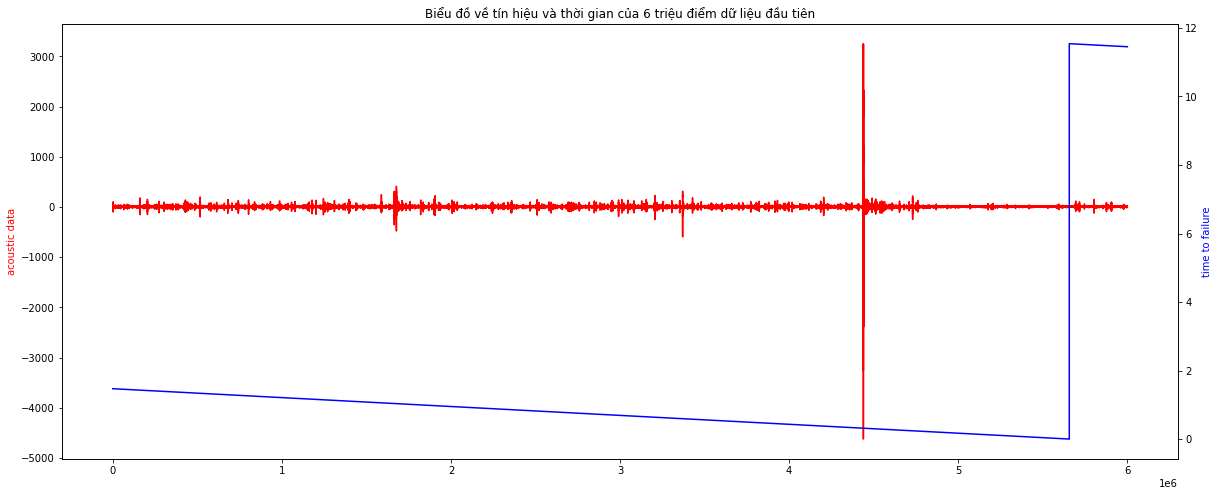

In [22]:
train_samples = pd.read_csv('data/train.csv', nrows=6000000)
fig, ax1 = plt.subplots(figsize=(20, 8))
plt.plot(train_samples.acoustic_data,color='r')
ax1.set_ylabel('acoustic data',color='r')

ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='b')
plt.plot(train_samples.time_to_failure,color='b')

plt.title('Biểu đồ về tín hiệu và thời gian của 6 triệu điểm dữ liệu đầu tiên')
plt.show()

**Bình luận:** Việc trực quan hóa dữ liệu ở dạng time domain khá là khó để xác định nhiễu với một người không có kiến thức chuyên ngành về động đất như em. Có một vùng tín hiệu giao động mạnh nhưng có thể là dấu hiệu của một trận động đất chứ không phải một nhiễu.  
**Hướng giải quyết:** Chuyển trường dữ liệu từ thời gian qua miền tần số bằng cách dùng FFT   
**Công việc tiếp theo:** Chuyển dữ liệu qua miền tần số và trực quạn hóa tần số bằng cách sử dụng số phức 

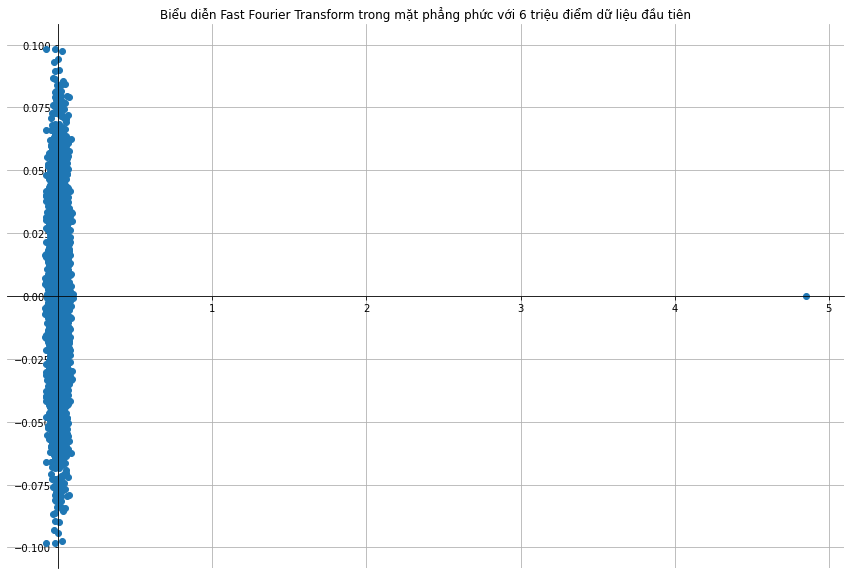

In [25]:
train_samples = pd.read_csv('data/train.csv', nrows=600000)
zc = np.fft.fft(train_samples.acoustic_data.values)/len(train_samples.acoustic_data.values)
realFFT = np.real(zc)
imagFFT = np.imag(zc)

fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True, which='both')
ax.plot(realFFT, imagFFT, 'o')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.title('Biểu diễn Fast Fourier Transform trong mặt phẳng phức với 6 triệu điểm dữ liệu đầu tiên')
plt.show()

**Bình luận:** Có một điểm nằm xa so với vùng tập trung nên có thể là điểm nhiễu.  
**Hướng xử lí:** Gán các điểm nhiễu bằng độ lớn trung bình của toàn bộ segment 

In [26]:
for index in range(len(realFFT)):
    a = np.sqrt(realFFT[index] ** 2 + imagFFT[index]**2)
    if a>0.1:
        realFFT[index] = np.mean(realFFT)
        imagFFT[index] = np.mean(imagFFT) 

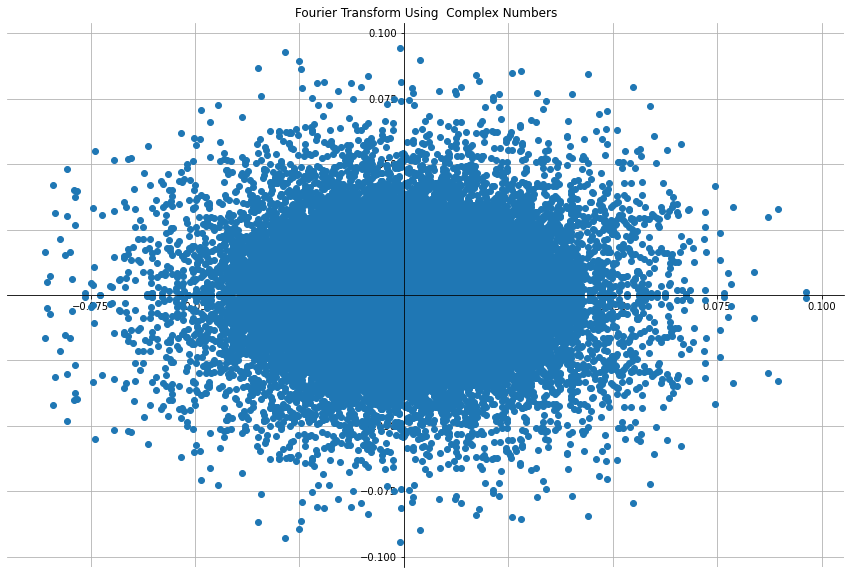

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.title('Fourier Transform Using  Complex Numbers')
ax.plot(realFFT, imagFFT, 'o')
plt.show()

**Bình luận:** Hướng xử lí này hợp lí trên 6 triệu dữ liệu đầu tiên    
**Công việc tiếp theo:** Ta thử trên một tập dữ liệu rộng hơn để có kết quả khách quan 

  0%|          | 0/5 [00:00<?, ?it/s]

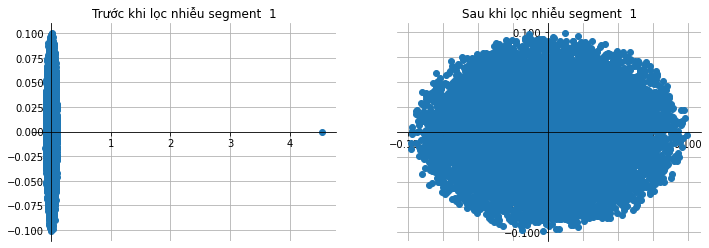

 20%|██        | 1/5 [00:15<01:01, 15.45s/it]

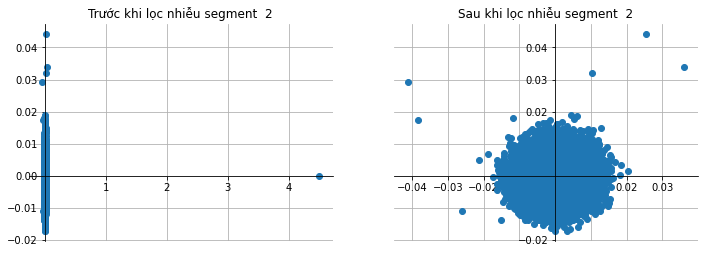

 40%|████      | 2/5 [00:30<00:45, 15.33s/it]

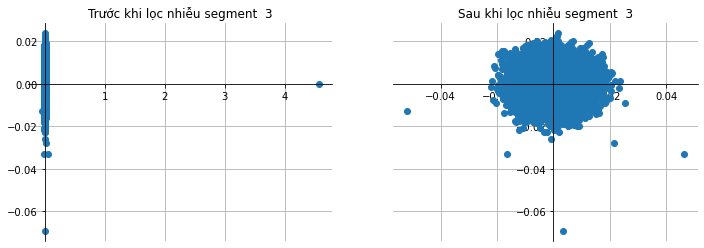

 60%|██████    | 3/5 [00:47<00:32, 16.01s/it]

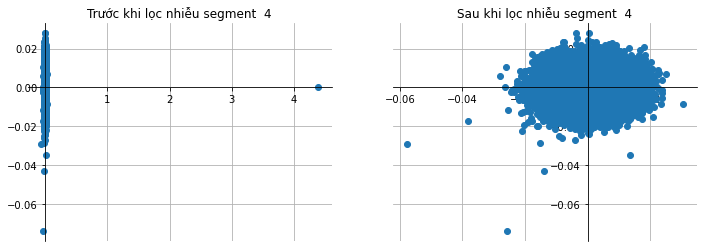

 80%|████████  | 4/5 [01:02<00:15, 15.63s/it]

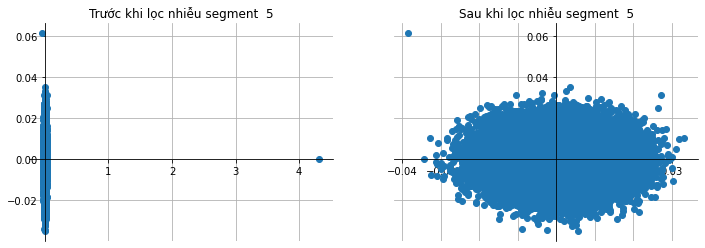

100%|██████████| 5/5 [01:16<00:00, 15.35s/it]


In [100]:
data = pd.read_csv('data/train.csv', nrows=30000000)
rows = 6000000
segments = int(30000000/rows)


for segment in tqdm(range(segments)):
    train_samples = data.acoustic_data.values[segment*rows : (segment+1)*rows]
    zc = np.fft.rfft(train_samples)/len(train_samples)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.grid(True, which='both')
    ax1.spines['left'].set_position('zero')
    ax1.spines['right'].set_color('none')
    ax1.spines['bottom'].set_position('zero')
    ax1.spines['top'].set_color('none')
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    ax1.plot(realFFT, imagFFT, 'o')
    ax1.set_title('Trước khi lọc nhiễu segment  ' + str(segment+1))
    
    ax2.grid(True, which='both')
    ax2.spines['left'].set_position('zero')
    ax2.spines['right'].set_color('none')
    ax2.spines['bottom'].set_position('zero')
    ax2.spines['top'].set_color('none')
    for index in range(len(realFFT)):
        a = np.sqrt(realFFT[index] ** 2 + imagFFT[index]**2)
        if a>0.1:
            realFFT[index] = np.mean(realFFT)
            imagFFT[index] = np.mean(imagFFT) 
        
    ax2.plot(realFFT, imagFFT, 'o')
    ax2.set_title('Sau khi lọc nhiễu segment  ' + str(segment+1))
    plt.show()

**Bình luận:** Phương pháp lọc nhiễu trên có ích cho 3 triệu dữ liệu đầu tiên. Nên có thể sử dụng cho các dữ liệu sau này.  
**Công việc:** Ta định nghĩa hai hàm lọc nhiễu cho dữ liệu miền thời gian và miền tần số 

In [11]:
def denoise_for_signal(data, threshold):
    zc = np.fft.rfft(data)/len(data)
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    
    for index in range(len(realFFT)):
        a = np.sqrt(realFFT[index] ** 2 + imagFFT[index]**2)
        if a>threshold:
            realFFT[index] = np.mean(realFFT)
            imagFFT[index] = np.mean(imagFFT) 
    return np.fft.irfft(realFFT + 1j * imagFFT)*len(data)

In [14]:
def denoise_for_fft(data, threshold):
    realFFT = np.real(data)
    imagFFT = np.imag(data)
    
    for index in range(len(realFFT)):
        a = np.sqrt(realFFT[index] ** 2 + imagFFT[index]**2)
        if a>threshold:
            realFFT[index] = np.mean(realFFT)
            imagFFT[index] = np.mean(imagFFT) 
    return realFFT,imagFFT

# Phân tích trích chọn đặc trưng 

**Vấn đề:**
- Đặc trưng của một bài toán học máy là một trong những yếu tố quyết định đến chất lượng và sự hiệu quả của mô hình.
- Do đó việc trích chọn đăc trưng cần được xem xét kĩ lưỡng và được phân tích rõ ràng nhờ và công cụ trực quan hóa dữ liệu 

**Công việc:** 
- Phân tích và trích chọn đặc trưng 

**Khó khăn**
- Vì dữ liệu tín hiệu hay timeseries có ít trường dữ liệu nên việc trực quan hóa khá khó khăn. Các đặc trưng và biểu đồ trực quan hóa bên dưới được em tham khảo một phần trong môn học Xử lí tiếng nói 

## Phân tích mối quan hệ giữa hai trường dữ liệu 

In [33]:
train_samples = pd.read_csv('data/train.csv', nrows=60000000)

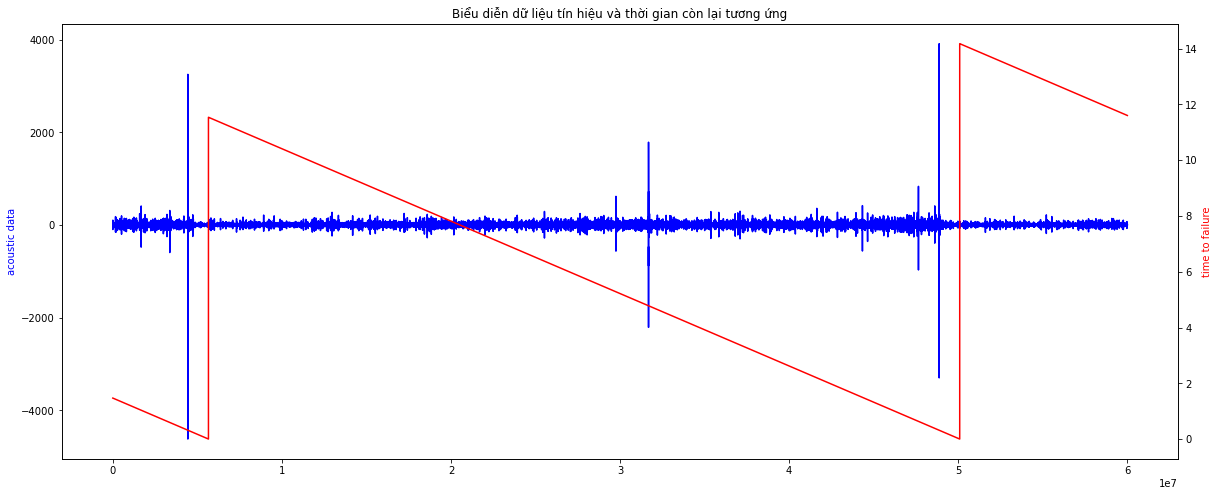

In [35]:
fig, ax1 = plt.subplots(figsize=(20, 8))
plt.plot(train_samples.acoustic_data,color='b')
ax1.set_ylabel('acoustic data',color='b')

ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='r')
plt.plot(train_samples.time_to_failure,color='r')

plt.title('Biểu diễn dữ liệu tín hiệu và thời gian còn lại tương ứng')
plt.show()

**Bình luận:** 
- Mỗi khi động đất xảy ra thì giá trị time_to_failure giảm xuống xấp xỉ 0  
- Qua quan sát, em thấy rằng trước khi xảy ra động đất sẽ có 1 lần tín hiệu có biên độ lớn đột ngột  
- Em tiến hành phân tích các trường dữ liệu chi tiết hơn trong phần sau 

## Phân tích các trường dữ liệu trong một chu kì động đất  

**Vấn đề:** Việc quan sát các trường dữ liệu biến đổi như thế nào trong một chu kì động đất sẽ biết được **xu hướng nào thì động đất dễ xảy ra, xu hướng nào thì động đất khó xảy ra**.   
**Công việc:**
- Tìm một chu kì động đất 
- Lần lượt phân tích hai trường thời gian và trường tín hiejeu

### Tìm một chu kì động đất  

In [4]:
train_samples = pd.read_csv('data/train.csv', nrows=60000000)
train_samples['time_to_failure'].min()

0.00069548217471

**Bình luận:** 
- Theo biểu đồ trên, trong 60 triệu điểm dữ liệu đầu sẽ có 2 lần xảy ra động đất
- Tuy nhiên, giá trị thời gian nhỏ nhất khác 0 chứng tỏ rằng khi xảy ra động đất, giá trị thời gian chỉ xấp xỉ không. Việc này hoàn toàn dễ hiểu bởi tín hiệu ban đầu là tín hiệu liên tục nhưng đã trải qua quá trình lấy mẫu (sampling) sau đó.

**Hướng giải quyết:** Sử dụng hai giá trị nhỏ nhất làm điểm bắt đầu và điểm kết thúc của chu kì .

In [5]:
start = train_samples[0:10000000][['time_to_failure']].idxmin().values[0]
end = train_samples[10000000:60000000][['time_to_failure']].idxmin().values[0]
train_one_period = train_samples[start+1:end]

### Trường thời gian còn lại 

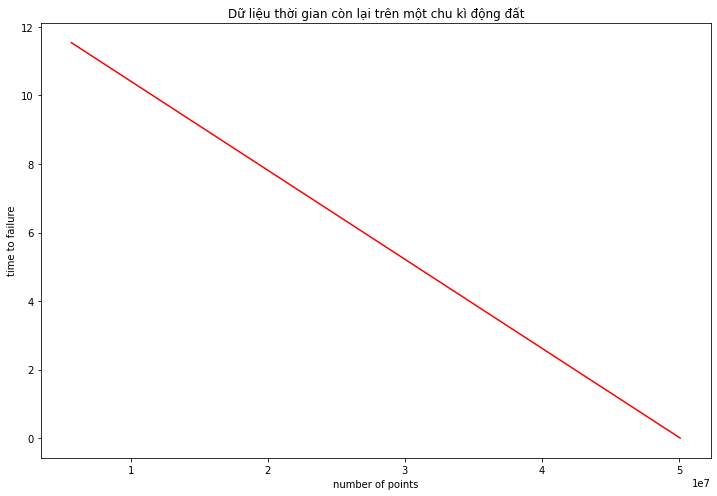

In [88]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train_one_period.time_to_failure, color = 'r')
plt.title('Dữ liệu thời gian còn lại trên một chu kì động đất')
plt.xlabel('number of points')
plt.ylabel('time to failure')
plt.show()

**Bình luận:** Khi biểu diễn trên tập dữ liệu lớn, trường thời gian như đang giảm tuyến tính. Em tiến hành biểu diễn một đoạn dữ liệu nhỏ để xác minh điều này.

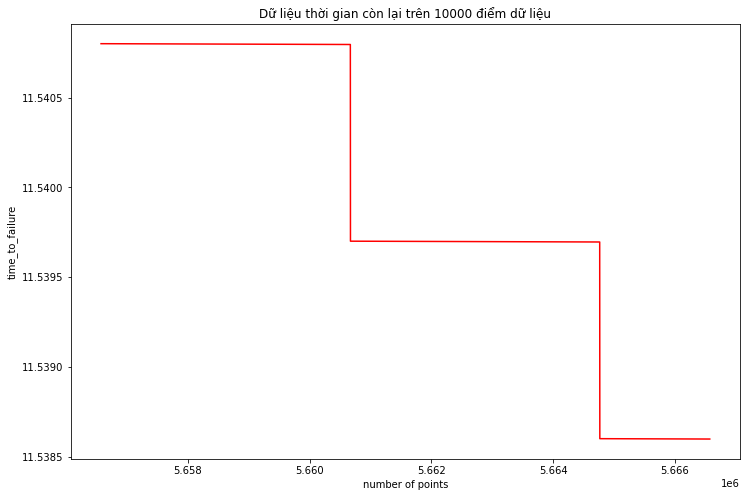

In [89]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train_one_period.time_to_failure[:10000], color = 'r')
plt.title('Dữ liệu thời gian còn lại trên 10000 điểm dữ liệu')
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
plt.show()

**Bình luận** Trên 10000 điểm dữ liệu, dữ liệu giảm theo dạng bậc thang, tức là dữ liệu dảm nhẹ rồi giảm đột ngột sau mỗi ~4000 điểm dữ liệu. Điều này có tính chu kì vì đây là đặc điểm của thí nghiệm, 4096 điểm dữ liệu sẽ được ghi lần lượt. Sau đó, thiết bị sẽ dừng trong khoảng 12 ms trước khi tiếp tục ghi. Việc dừng lại tạo ra việc lỡ mất các điểm dữ liệu trong khoảng thời gian đó. 

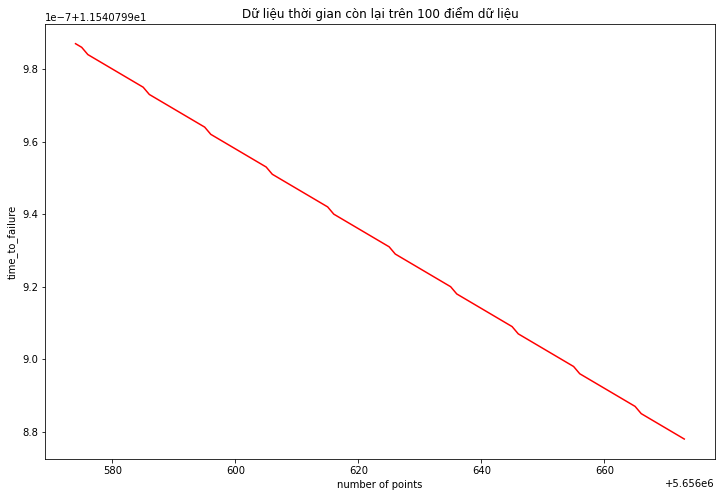

In [36]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train_one_period.time_to_failure[:100], color = 'r')
plt.title('Dữ liệu thời gian còn lại trên 100 điểm dữ liệu')
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
plt.show()

**Bình luận** Xét trên 100 điểm dữ liệu, trong từng khoảng 4096 điểm dữ liệu, dữ liệu cũng không giảm tuyến tính mà là giảm gấp khúc có chu kì.  
**Kết luận** Việc áp dụng tính chất giảm tuyến tính kể cả trong từng 4096 dữ liệu hay trong toàn bộ dữ liệu là không hợp lí 

### Trường tín hiệu 

**Bàn luận:** Do tập test cũng được chia thành các segment, nên việc trực quan hóa và phân tích trường tín hiệu cũng được thực hiện trên segment. 

**Công việc cụ thể:**
- B1: Chia dữ liệu của thành các segment
- B2: Thống kê đặc điểm, tính chất trên từng segment
- B3: Quan sát, bình luận sử biến đổi của các thống kê ấy khi thời gian cho lại cho đến khi xảy ra động đất dài, và khi thời gian còn lại cho đến khi xảy ra động đất ngắn.

**Lưu ý:** Tuy độ dài 1 segment của tập test là 150000, nhưng segment của tập train trong bước này chỉ để trực quan hóa nên sẽ thay đổi linh hoạt để đảm bảo tốc độ chạy chương trình.

#### Thống kê về sự phân bố 

  0%|          | 0/5 [00:00<?, ?it/s]

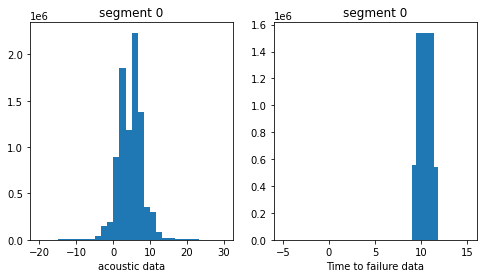

 20%|██        | 1/5 [00:00<00:01,  2.06it/s]

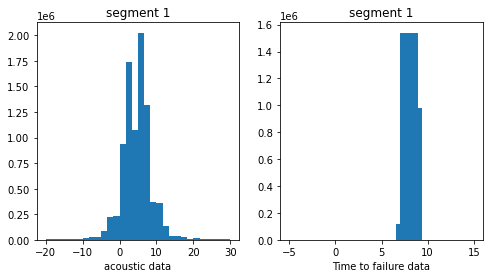

 40%|████      | 2/5 [00:01<00:01,  1.83it/s]

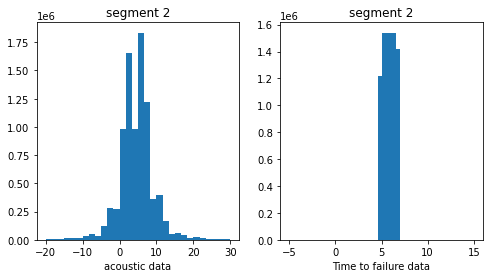

 60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

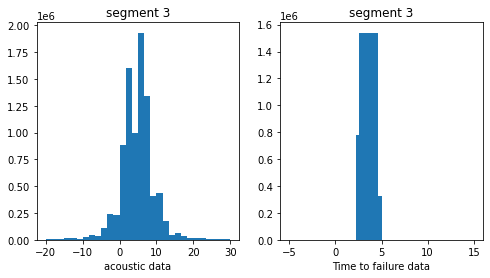

 80%|████████  | 4/5 [00:02<00:00,  1.55it/s]

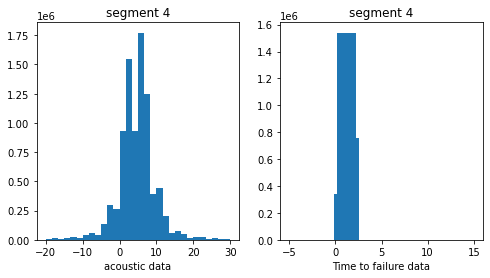

100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


In [99]:
rows = 8800000
segments = int(len(train_one_period)/rows)


for segment in tqdm(range(segments)):
    train_samples = train_one_period[segment*rows : (segment+1)*rows]
            
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8, 4))
    ax1.hist(train_samples['acoustic_data'],bins=30, range = [-20,30], align='mid')
    ax1.set_title('segment '+ str(segment))
    ax1.set_xlabel('acoustic data')
    
    ax2.hist(train_samples['time_to_failure'], bins=50, range = [-5,15], align='mid')
    ax2.set_xlabel('Time to failure data')
    ax2.set_title('segment '+ str(segment))

    plt.show()
    del train_samples

**Bình luận:** Về hình dạng, hình dạng phân bố của các trường dữ liệu tại các segment khác nhau khá tương đồng, khi càng gần thời điển xảy ra động đất, hình dạng phân bố có hơi nhọn hơn một chút.

#### Độ bao phủ của biên độ  (Amplitude Envelope) 

**Ý tưởng:** Như đã bình luận ở trên, khi sắp xảy ra động đất, tín hiệu của biên độ có một thời điểm tăng giảm đột ngột rất lớn. Vì vậy, xu hướng chung của biên độ có thể cũng có tính chất nào đó 

In [37]:
def get_envelope (input_signal, interval_length = 100000):    
    pos_signal = []
    neg_signal = []
    
    for segment in tqdm(range (0, int(len(input_signal)/interval_length))):
        pos_signal.append(input_signal[segment*interval_length:(segment+1)*interval_length]['acoustic_data'].max())
        neg_signal.append(input_signal[segment*interval_length:(segment+1)*interval_length]['acoustic_data'].min())
        
    return pos_signal,neg_signal

**Bình luận:** Hàm `get_envelope` trả về độ bao phủ dương và độ bao phủ âm của tín hiệu đầu vào. Các tính là duyệt qua các segment rồi lấy giá trị lớn nhất và nhỏ nhấ tương ứng trong từng segment 

100%|██████████| 444/444 [00:00<00:00, 1444.92it/s]


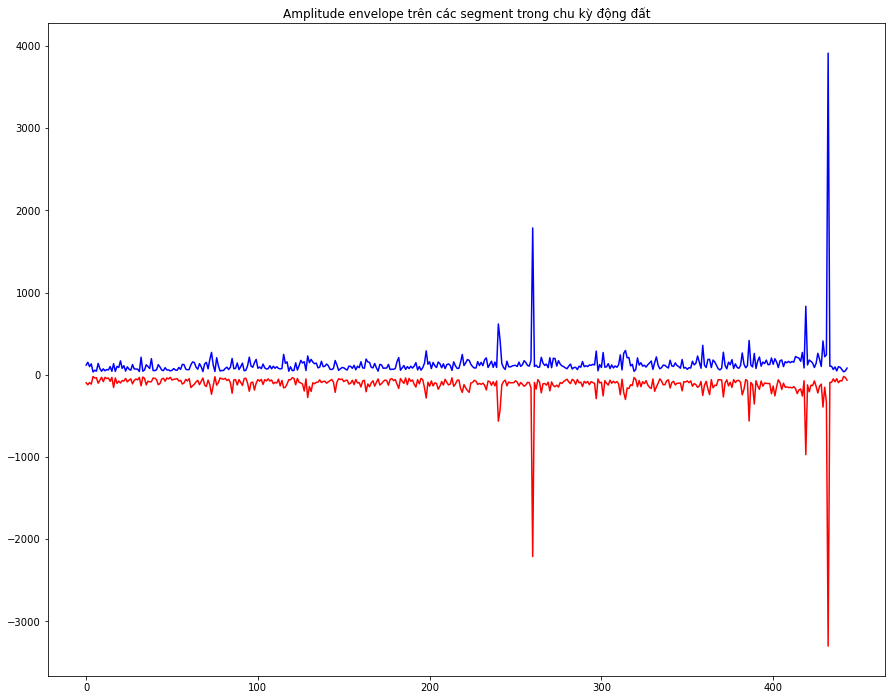

In [50]:
pos_amplitude_envelope, neg_amplitude_envelope = get_envelope(train_one_period)

fig, ax = plt.subplots(figsize=(15,12))
plt.plot(neg_amplitude_envelope, c="red")
plt.plot(pos_amplitude_envelope, c="blue")
plt.title("Amplitude envelope trên các segment trong chu kỳ động đất")

plt.show()

**Bình luận:** Theo chiều từ trái qua phải tương ứng với thời gian xảy ra động đất rút ngắn dần:
- Biên độ của tín hiệu có xu hướng tăng lên.
- Số lượng dao động đột biến (có độ lớn cao hơn hẳn các dao động xung quanh) cũng tăng lên.

#### Năng lượng trung bình (Root-mean-square energy)

**Ý tưởng:** Nhìn chung, các hiện tượng thiên nhiên đều xảy ra khi được kích hoạt bởi một nguồn năng lượng đủ mạnh. Lấy ý tưởng đó, em khảo sát chỉ số RMSE

In [39]:
def get_RMSE (input_signal, interval_length = 100000):    
    RMSE = []
    
    input_signal['score_square'] = input_signal['acoustic_data'] * input_signal['acoustic_data']
    for segment in tqdm(range (0, int(len(input_signal)/interval_length))):
        RMSE.append(np.sqrt(input_signal[segment*interval_length:(segment+1)*interval_length]['score_square'].sum()/interval_length))
    return RMSE

**Bình luận:** Hàm `get_RMSE` trả về độ đo RMSE. Các tính là duyệt qua các segment rồi lấy giá trị năng lượng trung bình của segment đó 

100%|██████████| 444/444 [00:00<00:00, 3023.25it/s]


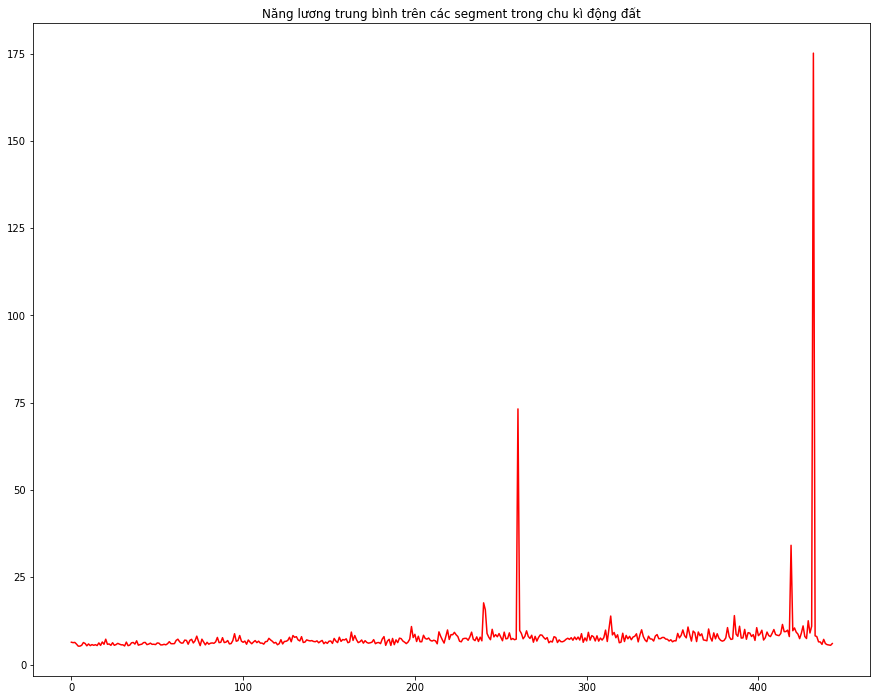

In [49]:
RMSE= get_RMSE(train_one_period)
fig, ax = plt.subplots(figsize=(15,12))
plt.plot(RMSE, c="red")
plt.title("Năng lương trung bình trên các segment trong chu kì động đất")
plt.show()

**Bình luận:** Theo chiều từ trái qua phải tương ứng với thời gian xảy ra động đất rút ngắn dần. Chỉ số RMSE của từng segment có xu hướng tăng dần và giao động bất ổn đinh hơn 

#### Số lần đổi dấu qua trục tọa độ (Zero-crossing rate)

**Ý tưởng:** Sự giao động bất ổn định phản ánh liên kết yếu kém của địa chất. Đây có thể là một trong những nhân tố báo hiệu một trận động đất sắp tới. 

In [46]:
def get_ZOR(input_signal, interval_length = 500000):
    ZOR = []
    for segment in tqdm(range (0, int(len(input_signal)/interval_length))):
        s = 0
        for index in range(segment*interval_length,(segment+1)*interval_length):
            if (input_signal[index]*input_signal[index -1] < 0):
                s+=1
        ZOR.append(s)
    return ZOR

100%|██████████| 88/88 [00:21<00:00,  4.05it/s]


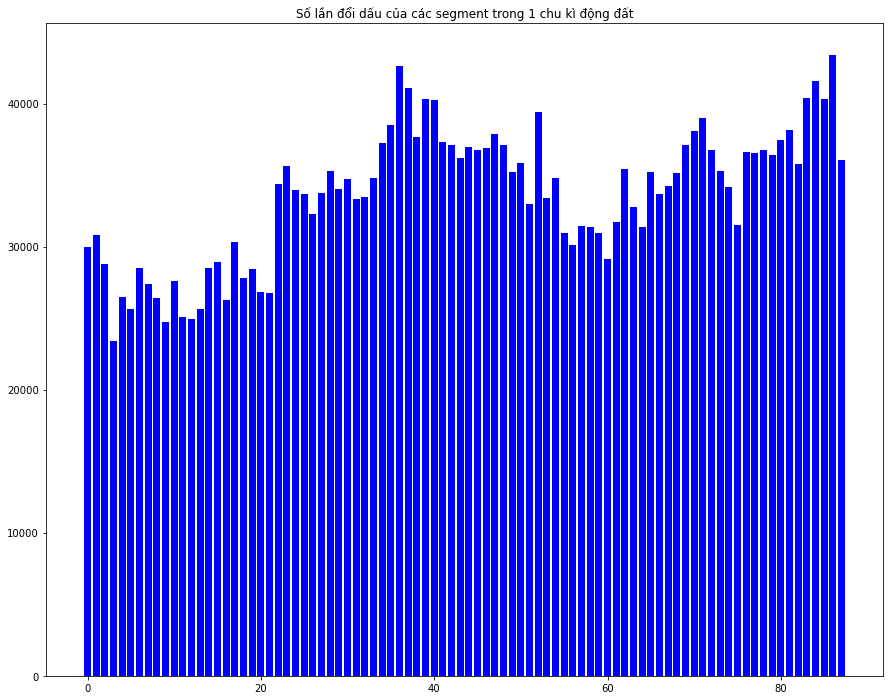

In [48]:
ZOR = get_ZOR(train_one_period.acoustic_data.values)
fig, ax = plt.subplots(figsize=(15,12))
plt.bar(range(len(ZOR)),ZOR, color='blue')
plt.title("Số lần đổi dấu của các segment trong 1 chu kì động đất")
plt.show()

**Bình luận:** Khoảng 1/3 lương segment đầu, số lần đổi dấu nhỏ hơn 2/3 lượng segment còn lại 

#### Khảo sát trong miền tần số

  0%|          | 0/10 [00:00<?, ?it/s]

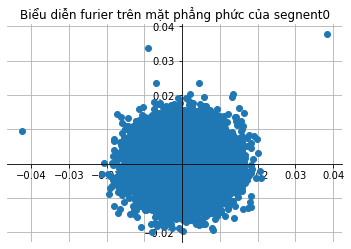

 10%|█         | 1/10 [00:09<01:24,  9.43s/it]

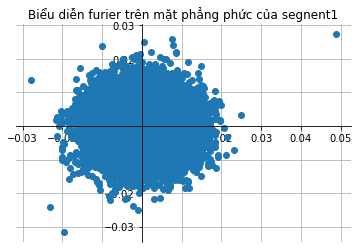

 20%|██        | 2/10 [00:19<01:20, 10.07s/it]

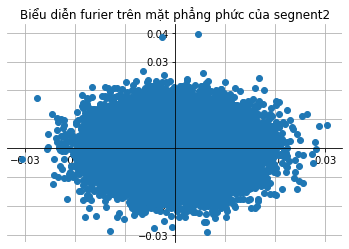

 30%|███       | 3/10 [00:28<01:04,  9.21s/it]

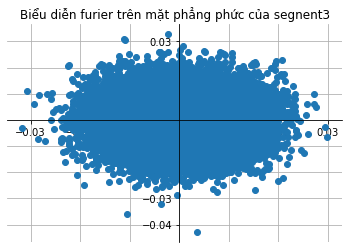

 40%|████      | 4/10 [00:35<00:51,  8.61s/it]

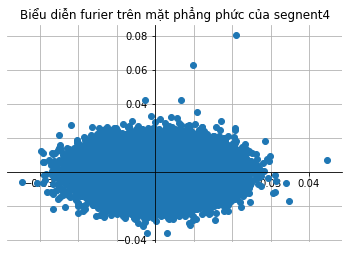

 50%|█████     | 5/10 [00:43<00:41,  8.36s/it]

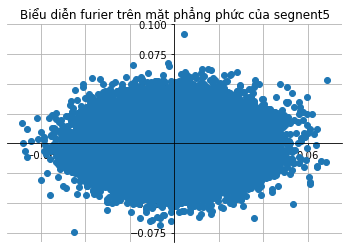

 60%|██████    | 6/10 [00:51<00:32,  8.21s/it]

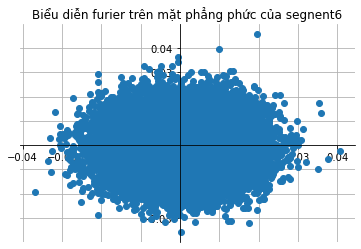

 70%|███████   | 7/10 [00:59<00:24,  8.05s/it]

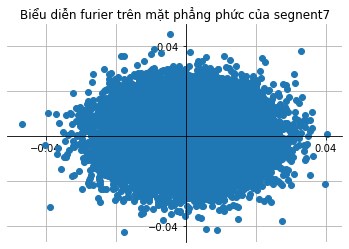

 80%|████████  | 8/10 [01:07<00:16,  8.19s/it]

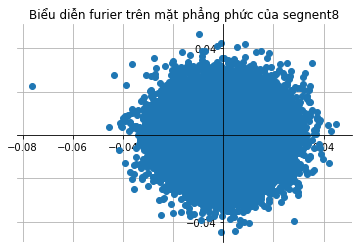

 90%|█████████ | 9/10 [01:15<00:08,  8.06s/it]

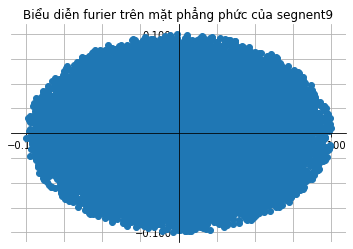

100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


In [51]:
rows = 4400000
segments = int(len(train_one_period)/rows)


for segment in tqdm(range(segments)):
    train_samples = train_one_period.acoustic_data.values[segment*rows : (segment+1)*rows]
    zc = np.fft.rfft(train_samples)/len(train_samples)
    realFFT, imagFFT = denoise_for_fft(zc, 0.1) 
            
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.grid(True, which='both')
    ax1.spines['left'].set_position('zero')
    ax1.spines['right'].set_color('none')
    ax1.spines['bottom'].set_position('zero')
    ax1.spines['top'].set_color('none')    
    ax1.plot(realFFT, imagFFT, 'o')
    ax1.set_title('Biểu diễn furier trên mặt phẳng phức của segnent' + str(segment))
    
    plt.show()

**Bình luận** Theo chiều từ trên xuống dưới tương ứng với thời gian xảy ra động đất rút ngắn dần, các điểm biểu diễn của tần số trên trục phức ngày càng phình to hơn.   
**Kết luận:** Các chỉ số thống kê của FFT có liên quan tới thời gian còn lại cho trận động đất tiếp theo.

# Phân tích sự tương đồng giữa dữ liệu train và dữ liệu test

**Vấn đề:**
- Phân tính sự tương đồng giữa dữ liệu train và dữ liệu test nhằm chắc chắn rằng dữ liệu chạy tốt trên tập validation thì sẽ chạy tốt trên tập test. 

**Công việc:** 
- Phân tích sự tương đồng thông qua phân bố của trường dữ liệu tín hiệu  

In [93]:
train_samples = pd.read_csv('data/train.csv', nrows=150000)
test1 = pd.read_csv('data/test/seg_00030f.csv') 
test2 = pd.read_csv('data/test/seg_1dec9c.csv') 
test3 = pd.read_csv('data/test/seg_5cfba9.csv') 

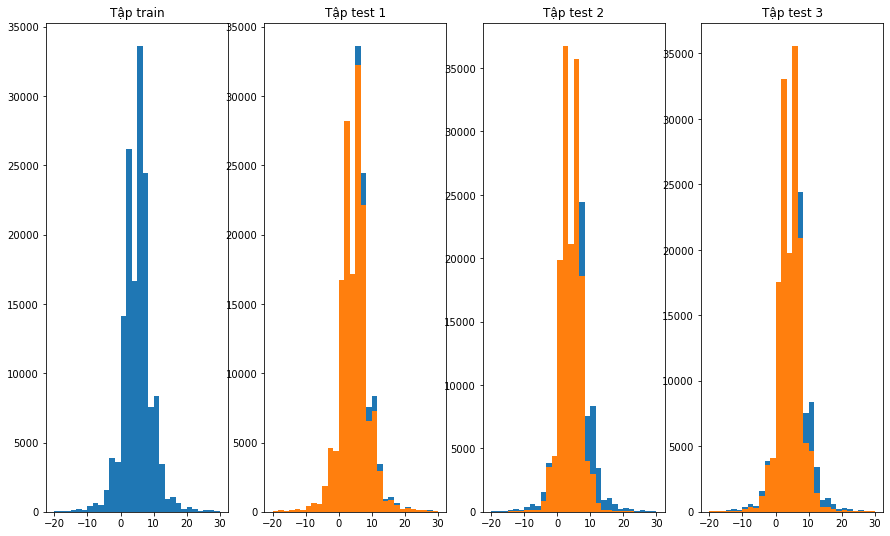

In [98]:
fig, (ax0, ax1, ax2,ax3) = plt.subplots(1, 4, figsize=(15,9))
ax0.set_title("Tập train")
ax1.set_title("Tập test 1")
ax2.set_title("Tập test 2")
ax3.set_title("Tập test 3")

ax0.hist(train_samples['acoustic_data'], bins=30, range = [-20,30], align='mid')
ax1.hist(train_samples['acoustic_data'], bins=30, range = [-20,30], align='mid')
ax2.hist(train_samples['acoustic_data'], bins=30, range = [-20,30], align='mid')
ax3.hist(train_samples['acoustic_data'], bins=30, range = [-20,30], align='mid')

ax1.hist(test1['acoustic_data'], bins=30, range = [-20, 30], align='mid')
ax2.hist(test2['acoustic_data'], bins=30, range = [-20, 30], align='mid')
ax3.hist(test3['acoustic_data'], bins=30, range = [-20, 30], align='mid')

plt.show()

**Bình luận:** Từ phân bố trên, ta có thể thấy rằng mức độ phân bố của tín hiệu tại các tập test và tập train là tương đương nhau.

# Trích chọn đặc trưng 

Dưới đây là hai hàm trích chọn đăng trưng em không dùng thư viện. Công dụng sẽ được em giải thích chi tiết phía dưới:

## Trích chọn đặc trưng 

In [ ]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [ ]:
#Chênh lệch trung bình giữa các giá trị liên tiếp về giá trị phần trăm;
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

**Vấn đề:** Để huấn luyện mô hình học máy cần trích chọn các đặc trưng cần thiết.  
**Công việc:** Trích chọn một số đặc trưng để phục vụ cho mô hình học máy
Mỗi dòng trong file test có 150000 cột tín hiệu. Vì vậy,em dùng hàm for để đọc, mỗi lần đọc lấy ra 150000 dữ liệu từ tập train rồi tiến hành trích chọn đăng trưng ngay sau đó.
Có hai hướng trích chọn đăc trưng:
- Lấy nguyên dữ liệu **raw** để sử dụng cho mô hình deep learning.
- Trích chọn các feature để đưa vào các mô hình học máy. 

Một số feature được lưa chọn để đưa vào mô hình học máy:
- Trong trường biểu diễn ban đầu 
    - Một số tổng hợp thông thường: mean, std, min, max  
    - Chênh lệch trung bình giữa các giá trị liên tiếp về giá trị tuyệt đối và giá trị phần trăm;   
    - Tổng hợp nói trên cho các giá trị 10000 và 50000 đầu tiên và cuối cùng 
    - Thương, hiệu giữa đồ lớn max và abs(min), đếm các khoảng cách max và min > một ngưỡng.  
    - Tính toán Quantile
    - Trend features   
    - Rolling features tisnht toán các chỉ số bằng cách dùng cửa sổ cuoojn

Quantile: q-th quantile tính toán lượng tử thứ q ở phân bố mô tả sự phân bố và sự phân tán của tập dữ liệu trong từng phần. 
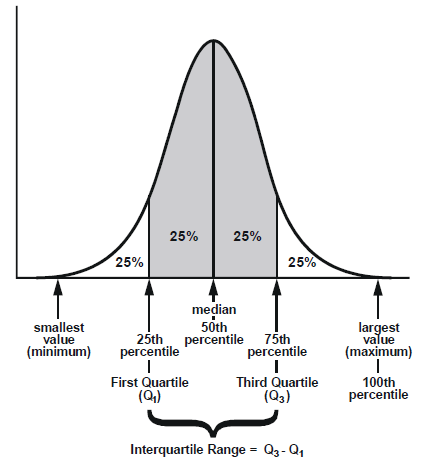

In [ ]:
x = pd.Series(train['acoustic_data'].values)
change = (np.diff(x) / x[:-1]).values

In [ ]:
rows = 150000
parts = int(60000000/rows)

X= pd.DataFrame(index=range(parts), dtype=np.float64)
Y= pd.DataFrame(index=range(parts), dtype=np.float64,columns=['time_to_failure']) 

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

for segment in tqdm(range(parts)): 
    data = pd.read_csv('data/train.csv', nrows = rows, skiprows=segment*rows+1)
    x = data.iloc[:,[0]].values
    x = pd.Series(x.reshape(len(x),))
    y = data.iloc[:,[1]].values[-1]
    
    Y.loc[segment, 'time_to_failure'] = y
    
    #Một số tổng hợp thông thường: mean, std, min, max
    X.loc[segment, 'mean'] = x.mean()
    X.loc[segment, 'std'] = x.std()
    X.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X.loc[segment, 'abs_std'] = np.abs(x).std()
    X.loc[segment, 'max'] = x.max()
    X.loc[segment, 'min'] = x.min()
    X.loc[segment, 'abs_max'] = np.abs(x).max()
    X.loc[segment, 'abs_min'] = np.abs(x).min()
    X.loc[segment, 'med'] = x.median()
    
    #Chênh lệch trung bình giữa các giá trị liên tiếp về giá trị tuyệt đối và giá trị phần trăm;
    X.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X.loc[segment, 'mean_change_rate'] = calc_change_rate(x)

    #Lấy mẫu n n phần tử cuối cùng rồi tính toán 
    X.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X.loc[segment, 'min_last_10000'] = x[-10000:].min()
    

    X.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X.loc[segment, 'max_last_10000'] = x[-10000:].max()

    
    X.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    #Thương, hiệu giữa đồ lớn max và abs(min), đếm các khoảng cách max và min > một ngưỡng 
    X.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X.loc[segment, 'sum'] = x.sum()
    
    #Tính toán Quantile
    X.loc[segment, 'q25'] = np.quantile(x, 0.25)
    X.loc[segment, 'q75'] = np.quantile(x, 0.75)
    X.loc[segment, 'q90'] = np.quantile(x, 0.95)
   
    X.loc[segment, 'abs_q25'] = np.quantile(np.abs(x), 0.25)
    X.loc[segment, 'abs_q75'] = np.quantile(np.abs(x), 0.75)
    X.loc[segment, 'abs_q90'] = np.quantile(np.abs(x), 0.95)

    
    #trend
    X.loc[segment, 'trend'] = add_trend_feature(x)
    X.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)

    
    #Một số chỉ số khác 
    X.loc[segment, 'mad'] = x.mad()
    X.loc[segment, 'kurt'] = x.kurtosis()
    X.loc[segment, 'skew'] = x.skew()
    X.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    
    #rolling 
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        
        X.loc[segment, 'q25_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.25)
        X.loc[segment, 'q50_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.50)
        X.loc[segment, 'q75_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.75)
        X.loc[segment, 'q90_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.90)

        X.loc[segment, 'q25_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.25)
        X.loc[segment, 'q50_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.50)
        X.loc[segment, 'q75_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.75)
        X.loc[segment, 'q90_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.90)
        
        X.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))

In [ ]:
X.head()

In [ ]:
Y.head()

Lưu dữ liệu đặc trưng để dùng cho những lần sử dụng sau này nếu cần.

**Kết quả:** Một danh sách các đặc trưng để đưa vào mô hình học máy  
**Bình luận:** Các đặc trưng này thì chưa có tính thực nghiệm nên cần thử nghiệm thêm 

In [ ]:
X.to_csv('input2')

# Modeling

Có hai hướng tiếp cận là dùng kĩ thuật học máy cho các đặc trưng đã trích chọn và dùng deeplearning

## Hướng tiếp cận machine learning

**Vấn đề:** Cần thử các mô hình học máy khác nhau để đánh giá kết quả  
**Công việc:** Cài đặt các mô hình học máy  
**Kết quả dự kiến:** Điểm đánh giá của từng mô hình   

Chuẩn hóa dữ liệu về trung bình = 0, độ lệch chuẩn về 1

In [ ]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
scaler.fit(X) 
X = scaler.transform(X)

In [ ]:
pd.DataFrame(X)

Chia tập dữ liệu thành các tập train, test (validation)

In [ ]:
from sklearn.model_selection import train_test_split
Y = Y.values.reshape((1,len(Y.values)))[0]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Lưu kết quả của các mô hình

In [ ]:
result = pd.DataFrame()
result['actually'] = y_test

### Mô hình SVR

In [ ]:
#SVR 
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import NuSVR, SVR 
from sklearn.metrics import mean_absolute_error 

Lập các bộ tham số để train nhằm tìm ra bộ tham số phù hợp nhất

In [ ]:
# params = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'degree': [1,3,5],
#     'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1], 
#     'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]
# }

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [1, 3, 5, 7, 9],
    'gamma': ['scale', 'auto'], 
    'C': [0.1, 0.5, 0.75, 1, 1.25, 1.5, 2]
}

gridSVR = GridSearchCV(SVR(), params, scoring='neg_mean_absolute_error')

In [ ]:
gridSVR.fit(X_train, y_train)
print(gridSVR.best_params_)

Dự đoán và tính sai số 

In [ ]:
y_predict = gridSVR.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)
#1.6741582853492696

In [ ]:
result['svr_predict']= y_predict
result['svr_mae'] = abs(y_predict-y_test)

### Mô hình Xgb

In [ ]:
# Extreme Gradient Boosting
import xgboost as xgb 

Lập các bộ tham số để train nhằm tìm ra bộ tham số phù hợp nhất

In [ ]:
# params = {
#     'n_estimators': [5, 10, 50], 
#      'max_depth': [1, 5, 10]
# }

# params = {'eta': [0.03],
#           'max_depth': [9],
#           'subsample': [0.85],
#           'objective': ['reg:squarederror'],
#           'eval_metric': ['mae'],
#           'nthread': [4]}

params = {'n_estimators': [5, 10, 50],
          'max_depth': [1, 5, 10],
          'eta': [0.01, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5],
          'gamma': [0, 1, 2,3],
          'max_depth': [1, 3, 5, 7, 9, 11],
          'min_child_weight': [0, 1, 3, 5],
          'subsample': [0.1, 0.3, 0.5, 0.7, 0.9],
          'objective': ['reg:squarederror'],
          'eval_metric': ['mae'],
          'nthread': [4]}


gridXGB = GridSearchCV(xgb.XGBRegressor(), params, scoring='neg_mean_absolute_error')

In [ ]:
gridXGB.fit(X_train, y_train)
print(gridXGB.best_params_)

Dự đóa y và tính sai số

In [ ]:
y_predict = gridXGB.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)

In [ ]:
result['xgb_predict']= y_predict
result['xgb_mae'] = abs(y_predict-y_test)

### Mô hình học sâu 

In [ ]:
import keras
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.models import Sequential
from keras import optimizers

In [ ]:
model = Sequential()
model.add(Dense(83 , input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(38,  kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='logcosh')

In [ ]:
# input_dim = X_train.shape[1]
# activation = 'tanh'
# classes = 1 #the output labels
# model = Model(input_dim = input_dim, activation = activation, classes = classes)

In [ ]:
filepath = "weights.hdf5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),                                   #Stop training if no improvement is seen in Validation loss after 10 attempts
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta=1.5e-5, patience=5, verbose=1, mode='min'),                    #Slow down Learning rate if Validation Loss is not Decreasing after 5 attempts
    ModelCheckpoint(filepath, save_best_only=True,  save_weights_only=False, monitor='val_loss', mode='min', verbose=1) #Best Model weights are saved in hdf5 file every epoch
]

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=callbacks, verbose=1)

In [ ]:
result

### Visualize result

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(132),result['svr_mae'])
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(132),result['lgb_mae'])
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(132),result['xgb_mae'])
plt.show()

In [ ]:
result

### Save model

In [ ]:
#save model
import pickle

In [ ]:
filename = "SVRModel.pkl"
with open(filename, 'wb') as file:
    pickle.dump(gridSVR, file)

In [ ]:
with open(filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [ ]:
y_predict = pickle_model.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)